# Baseball Project

In [74]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PowerTransformer

# machine learning
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error

# warnings
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

In [3]:
# batting data for National League Central Division players from 2010-2025
batting = pd.read_csv("new_data/batting.csv")
batting

,Name,Age,#days,Lev,Tm,G,PA,AB,R,H,2B,3B,HR,RBI,BB,IBB,SO,HBP,SH,SF,GDP,SB,CS,BA,OBP,SLG,OPS,mlbID,Year
0,Fernando Abad,24,5555,Maj-NL,Houston,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.000,0.000,0.000,0.000,472551,2010
1,Bobby Abreu,36,5534,Maj-AL,Los Angeles,154,667,573,88,146,41,1,20,78,87,3,132,2,0,5,13,24,10,0.255,0.352,0.435,0.787,110029,2010
2,Tony Abreu,25,5534,Maj-NL,Arizona,81,201,193,16,45,11,1,1,13,4,0,47,0,0,4,8,2,1,0.233,0.244,0.316,0.560,473234,2010
3,Jeremy Affeldt,31,5709,Maj-NL,San Francisco,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.000,0.000,0.000,0.000,346793,2010
4,Cory Aldridge,31,5618,Maj-AL,Los Angeles,5,13,13,0,1,0,1,0,1,0,0,5,0,0,0,0,0,0,0.077,0.077,0.231,0.308,400139,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13274,Juan Yepez,26,424,Maj-NL,Washington,62,249,226,32,64,15,0,6,26,18,0,42,1,1,3,9,2,1,0.283,0.335,0.429,0.764,660766,2024
13275,Nick Yorke,22,424,Maj-NL,Pittsburgh,11,42,37,4,8,0,0,2,5,4,0,12,0,0,1,0,2,0,0.216,0.286,0.378,0.664,694377,2024
13276,Masataka Yoshida,30,426,Maj-AL,Boston,107,417,374,45,105,20,0,10,56,27,0,51,14,0,2,6,2,0,0.281,0.350,0.414,0.765,807799,2024
13277,Jacob Young,24,424,Maj-NL,Washington,150,521,468,75,120,24,1,3,36,30,0,102,12,9,2,11,33,10,0.256,0.316,0.331,0.648,696285,2024


In [4]:
# player WAR of National League Central Division players from 2010-2025
bwar = pd.read_csv("new_data/bwar.csv")
bwar

,name_common,mlb_ID,year_ID,team_ID,stint_ID,lg_ID,pitcher,WAR
0,David Aardsma,430911.0,2010,SEA,1,AL,Y,0.00
1,David Aardsma,430911.0,2012,NYY,1,AL,Y,NaN
2,David Aardsma,430911.0,2013,NYM,1,NL,Y,0.00
3,David Aardsma,430911.0,2015,ATL,1,NL,Y,-0.01
4,Fernando Abad,472551.0,2010,HOU,1,NL,Y,-0.02
...,...,...,...,...,...,...,...,...
23409,Mike Zunino,572287.0,2022,TBR,1,AL,N,-0.82
23410,Mike Zunino,572287.0,2023,CLE,1,AL,N,-0.56
23411,Tony Zych,543964.0,2015,SEA,1,AL,Y,NaN
23412,Tony Zych,543964.0,2016,SEA,1,AL,Y,NaN


In [5]:
# generate a column to align next year's WAR with current year's batting stats
bwar['fake_year_id'] = bwar['year_ID'] - 1
bwar.head()

,name_common,mlb_ID,year_ID,team_ID,stint_ID,lg_ID,pitcher,WAR,fake_year_id
0,David Aardsma,430911.0,2010,SEA,1,AL,Y,0.00,2009
1,David Aardsma,430911.0,2012,NYY,1,AL,Y,NaN,2011
2,David Aardsma,430911.0,2013,NYM,1,NL,Y,0.00,2012
3,David Aardsma,430911.0,2015,ATL,1,NL,Y,-0.01,2014
4,Fernando Abad,472551.0,2010,HOU,1,NL,Y,-0.02,2009


In [6]:
# join response variable i.e. next year's WAR, for all players 
df = pd.merge(left=batting, right=bwar, how="inner", left_on=["mlbID", "Year"], right_on=["mlb_ID", "fake_year_id"])
df = df.rename({"WAR":"next_WAR"}, axis=1)

# get current year's war using merge
df = pd.merge(left=df, right=bwar[["WAR","mlb_ID","year_ID"]], how="inner", left_on=["mlbID", "Year"], right_on=["mlb_ID", "year_ID"])

df # final usable dataframe

,Name,Age,#days,Lev,Tm,G,PA,AB,R,H,2B,3B,HR,RBI,BB,IBB,SO,HBP,SH,SF,GDP,SB,CS,BA,OBP,SLG,OPS,mlbID,Year,name_common,mlb_ID_x,year_ID_x,team_ID,stint_ID,lg_ID,pitcher,next_WAR,fake_year_id,WAR,mlb_ID_y,year_ID_y
0,Fernando Abad,24,5555,Maj-NL,Houston,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.000,0.000,0.000,0.000,472551,2010,Fernando Abad,472551.0,2011,HOU,1,NL,Y,0.00,2010,-0.02,472551.0,2010
1,Bobby Abreu,36,5534,Maj-AL,Los Angeles,154,667,573,88,146,41,1,20,78,87,3,132,2,0,5,13,24,10,0.255,0.352,0.435,0.787,110029,2010,Bobby Abreu,110029.0,2011,LAA,1,AL,N,1.60,2010,1.85,110029.0,2010
2,Jeremy Affeldt,31,5709,Maj-NL,San Francisco,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.000,0.000,0.000,0.000,346793,2010,Jeremy Affeldt,346793.0,2011,SFG,1,NL,Y,0.03,2010,-0.02,346793.0,2010
3,Eli\xc3\xa9zer Alfonzo,31,5632,Maj-AL,Seattle,12,41,41,4,9,1,0,1,4,0,0,10,0,0,0,2,0,0,0.220,0.220,0.317,0.537,425769,2010,Eliézer Alfonzo,425769.0,2011,COL,1,NL,N,0.05,2010,-0.22,425769.0,2010
4,Brandon Allen,24,5534,Maj-NL,Arizona,21,56,45,5,12,3,0,1,6,10,1,20,0,0,1,0,0,0,0.267,0.393,0.400,0.793,450315,2010,Brandon Allen,450315.0,2011,ARI,1,NL,N,0.11,2010,0.25,450315.0,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12963,Mike Yastrzemski,33,424,Maj-NL,San Francisco,140,474,428,60,99,16,9,18,57,38,1,124,6,1,1,5,3,2,0.231,0.302,0.437,0.739,573262,2024,Mike Yastrzemski,573262.0,2025,SFG,1,NL,N,1.78,2024,2.14,573262.0,2024
12964,Christian Yelich,32,492,Maj-NL,Milwaukee,73,315,270,44,85,12,3,11,42,40,3,58,2,1,1,3,21,1,0.315,0.406,0.504,0.909,592885,2024,Christian Yelich,592885.0,2025,MIL,1,NL,N,3.08,2024,2.21,592885.0,2024
12965,Nick Yorke,22,424,Maj-NL,Pittsburgh,11,42,37,4,8,0,0,2,5,4,0,12,0,0,1,0,2,0,0.216,0.286,0.378,0.664,694377,2024,Nick Yorke,694377.0,2025,PIT,1,NL,N,0.28,2024,-0.21,694377.0,2024
12966,Masataka Yoshida,30,426,Maj-AL,Boston,107,417,374,45,105,20,0,10,56,27,0,51,14,0,2,6,2,0,0.281,0.350,0.414,0.765,807799,2024,Masataka Yoshida,807799.0,2025,BOS,1,AL,N,0.17,2024,1.41,807799.0,2024


In [7]:
df.columns

Index(['Name', 'Age', '#days', 'Lev', 'Tm', 'G', 'PA', 'AB', 'R', 'H', '2B',
       '3B', 'HR', 'RBI', 'BB', 'IBB', 'SO', 'HBP', 'SH', 'SF', 'GDP', 'SB',
       'CS', 'BA', 'OBP', 'SLG', 'OPS', 'mlbID', 'Year', 'name_common',
       'mlb_ID_x', 'year_ID_x', 'team_ID', 'stint_ID', 'lg_ID', 'pitcher',
       'next_WAR', 'fake_year_id', 'WAR', 'mlb_ID_y', 'year_ID_y'],
      dtype='object')

In [8]:
# drop duplicate columns 
df = df.drop(["mlb_ID_x", "year_ID_x", "fake_year_id", "Tm", "mlb_ID_y", "year_ID_y"], axis=1)
df.head()
df

,Name,Age,#days,Lev,G,PA,AB,R,H,2B,3B,HR,RBI,BB,IBB,SO,HBP,SH,SF,GDP,SB,CS,BA,OBP,SLG,OPS,mlbID,Year,name_common,team_ID,stint_ID,lg_ID,pitcher,next_WAR,WAR
0,Fernando Abad,24,5555,Maj-NL,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.000,0.000,0.000,0.000,472551,2010,Fernando Abad,HOU,1,NL,Y,0.00,-0.02
1,Bobby Abreu,36,5534,Maj-AL,154,667,573,88,146,41,1,20,78,87,3,132,2,0,5,13,24,10,0.255,0.352,0.435,0.787,110029,2010,Bobby Abreu,LAA,1,AL,N,1.60,1.85
2,Jeremy Affeldt,31,5709,Maj-NL,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.000,0.000,0.000,0.000,346793,2010,Jeremy Affeldt,SFG,1,NL,Y,0.03,-0.02
3,Eli\xc3\xa9zer Alfonzo,31,5632,Maj-AL,12,41,41,4,9,1,0,1,4,0,0,10,0,0,0,2,0,0,0.220,0.220,0.317,0.537,425769,2010,Eliézer Alfonzo,COL,1,NL,N,0.05,-0.22
4,Brandon Allen,24,5534,Maj-NL,21,56,45,5,12,3,0,1,6,10,1,20,0,0,1,0,0,0,0.267,0.393,0.400,0.793,450315,2010,Brandon Allen,ARI,1,NL,N,0.11,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12963,Mike Yastrzemski,33,424,Maj-NL,140,474,428,60,99,16,9,18,57,38,1,124,6,1,1,5,3,2,0.231,0.302,0.437,0.739,573262,2024,Mike Yastrzemski,SFG,1,NL,N,1.78,2.14
12964,Christian Yelich,32,492,Maj-NL,73,315,270,44,85,12,3,11,42,40,3,58,2,1,1,3,21,1,0.315,0.406,0.504,0.909,592885,2024,Christian Yelich,MIL,1,NL,N,3.08,2.21
12965,Nick Yorke,22,424,Maj-NL,11,42,37,4,8,0,0,2,5,4,0,12,0,0,1,0,2,0,0.216,0.286,0.378,0.664,694377,2024,Nick Yorke,PIT,1,NL,N,0.28,-0.21
12966,Masataka Yoshida,30,426,Maj-AL,107,417,374,45,105,20,0,10,56,27,0,51,14,0,2,6,2,0,0.281,0.350,0.414,0.765,807799,2024,Masataka Yoshida,BOS,1,AL,N,0.17,1.41


### Data Dictionary

Describe what each column in the data represents, find data types using df.dtypes

example: 

**`next_WAR`** - Response 

- `[int64]` Whether or not the batter swung (`1`) or took (`0`).

Features:

**`pitch_name`**

- `[object]` The name of the pitch type to be thrown.

**`release_extension`**

- `[float64]` Release extension of pitch in feet as tracked by Statcast.

**`release_pos_x`**

- `[float64]` Horizontal release position of the ball measured in feet from the catcher's perspective.

**`release_pos_y`**

- `[float64]` Release position of pitch measured in feet from the catcher's perspective.

**`release_pos_z`**

- `[float64]` Vertical release position of the ball measured in feet from the catcher's perspective.

**`release_speed`**

- `[float64]` Velocity of the pitch thrown (miles per hour).

### Look for missing values

In [9]:
df.shape

(12968, 35)

In [10]:
df[df["Year"]==2024]

,Name,Age,#days,Lev,G,PA,AB,R,H,2B,3B,HR,RBI,BB,IBB,SO,HBP,SH,SF,GDP,SB,CS,BA,OBP,SLG,OPS,mlbID,Year,name_common,team_ID,stint_ID,lg_ID,pitcher,next_WAR,WAR
12287,CJ Abrams,23,433,Maj-NL,138,602,541,79,133,29,6,20,65,40,3,128,16,1,4,4,31,12,0.246,0.314,0.433,0.747,682928,2024,CJ Abrams,WSN,1,NL,N,3.38,3.37
12288,Wilyer Abreu,25,424,Maj-AL,132,446,398,59,101,33,2,15,58,40,0,125,3,0,5,7,8,3,0.254,0.323,0.460,0.783,677800,2024,Wilyer Abreu,BOS,1,AL,N,3.21,3.40
12289,Luisangel Acu\xc3\xb1a,22,410,Maj-NL,17,43,42,6,12,2,1,3,6,1,0,8,0,0,0,1,0,1,0.286,0.302,0.595,0.898,682668,2024,Luisangel Acuña,NYM,1,NL,N,0.56,0.52
12290,Ronald Acu\xc3\xb1a Jr.,26,550,Maj-NL,49,222,192,38,48,8,1,4,15,27,0,53,3,0,0,4,16,3,0.250,0.351,0.365,0.716,660670,2024,Ronald Acuña Jr.,ATL,1,NL,N,2.97,0.02
12291,Willy Adames,28,420,Maj-NL,164,700,621,94,155,33,0,32,112,75,3,176,1,0,3,12,22,4,0.250,0.330,0.457,0.787,642715,2024,Willy Adames,SFG,1,NL,N,3.73,3.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12963,Mike Yastrzemski,33,424,Maj-NL,140,474,428,60,99,16,9,18,57,38,1,124,6,1,1,5,3,2,0.231,0.302,0.437,0.739,573262,2024,Mike Yastrzemski,SFG,1,NL,N,1.78,2.14
12964,Christian Yelich,32,492,Maj-NL,73,315,270,44,85,12,3,11,42,40,3,58,2,1,1,3,21,1,0.315,0.406,0.504,0.909,592885,2024,Christian Yelich,MIL,1,NL,N,3.08,2.21
12965,Nick Yorke,22,424,Maj-NL,11,42,37,4,8,0,0,2,5,4,0,12,0,0,1,0,2,0,0.216,0.286,0.378,0.664,694377,2024,Nick Yorke,PIT,1,NL,N,0.28,-0.21
12966,Masataka Yoshida,30,426,Maj-AL,107,417,374,45,105,20,0,10,56,27,0,51,14,0,2,6,2,0,0.281,0.350,0.414,0.765,807799,2024,Masataka Yoshida,BOS,1,AL,N,0.17,1.41


In [11]:
df[df["G"] < 2]

,Name,Age,#days,Lev,G,PA,AB,R,H,2B,3B,HR,RBI,BB,IBB,SO,HBP,SH,SF,GDP,SB,CS,BA,OBP,SLG,OPS,mlbID,Year,name_common,team_ID,stint_ID,lg_ID,pitcher,next_WAR,WAR
0,Fernando Abad,24,5555,Maj-NL,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,0.0,0.0,0.0,472551,2010,Fernando Abad,HOU,1,NL,Y,0.00,-0.02
2,Jeremy Affeldt,31,5709,Maj-NL,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,0.0,0.0,0.0,346793,2010,Jeremy Affeldt,SFG,1,NL,Y,0.03,-0.02
21,Burke Badenhop,27,5710,Maj-NL,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,488674,2010,Burke Badenhop,FLA,1,NL,Y,0.15,-0.02
40,Joe Beimel,33,5687,Maj-NL,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,0.0,0.0,0.0,346847,2010,Joe Beimel,PIT,1,NL,Y,-0.01,-0.01
42,Heath Bell,32,5553,Maj-NL,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,425514,2010,Heath Bell,SDP,1,NL,Y,0.00,-0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12010,Shelby Miller,32,941,Maj-NL,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,571946,2023,Shelby Miller,DET,1,AL,Y,NaN,0.00
12136,Josh Sborz,29,950,Maj-AL,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,0.0,0.0,0.0,622250,2023,Josh Sborz,TEX,1,AL,Y,NaN,0.00
12334,David Ba\xc3\xb1uelos,27,590,Maj-AL,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,675915,2024,David Bañuelos,BAL,1,AL,N,0.01,NaN
12577,Daniel Johnson,28,432,Maj-AL,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,669288,2024,Daniel Johnson,BAL,2,AL,N,0.07,-0.03


In [12]:
# Check for explicit missing values
(df.isna().sum() > 0).sum()

np.int64(6)

In [13]:
df = df.dropna()

In [14]:
df.shape

(11762, 35)

In [15]:
# Check if there are any implicit missing values
# Check if dtypes of all variables match what is expected, 
# example we would expect the R (run) variable to contain numbers so should be int or float type

In [16]:
# to look for implicit missing values in categorical variables, check all levels
df['team_ID'].unique() 

array(['HOU', 'LAA', 'SFG', 'COL', 'ARI', 'OAK', 'CIN', 'PIT', 'BOS',
       'BAL', 'TEX', 'WSN', 'TOR', 'DET', 'KCR', 'FLA', 'CHC', 'MIN',
       'LAD', 'SEA', 'SDP', 'NYM', 'STL', 'ATL', 'CHW', 'MIL', 'PHI',
       'CLE', 'TBR', 'NYY', 'MIA', 'ATH'], dtype=object)

In [17]:
# look for extreme outliers, example single variable boxplots

<Axes: xlabel='R', ylabel='Count'>

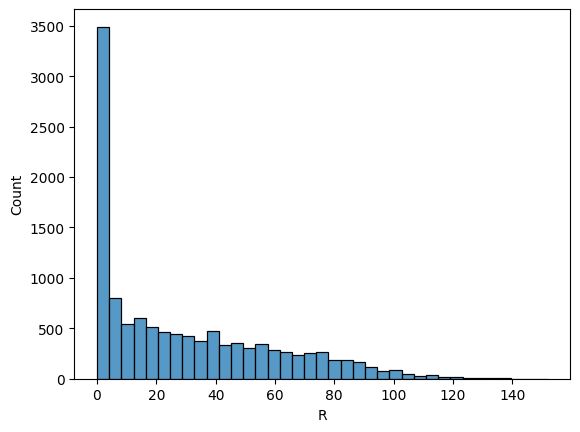

In [18]:
# check the shape of data
sns.histplot(df, x="R")

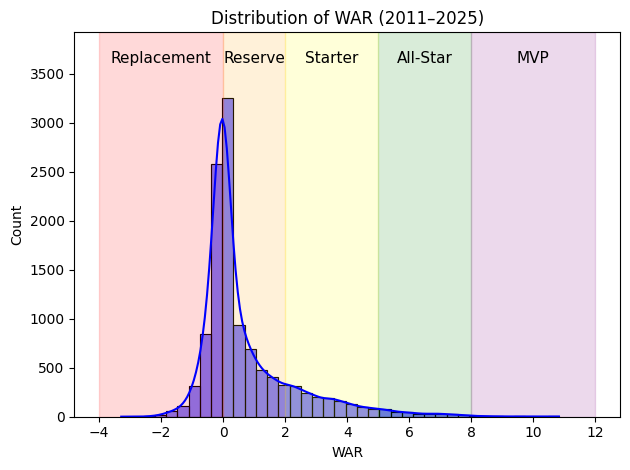

In [19]:
# distribution of WAR from 2011-2025
sns.histplot(data=df, x="next_WAR", bins=39, edgecolor="black", color="blue", kde=True)
plt.title("Distribution of WAR (2011–2025)")
plt.xlabel("WAR")

plt.ylim(top = plt.ylim()[1] * 1.15)   # adds 25% extra headroom

plt.axvspan(-4, 0, alpha=0.15, color='red')        # Replacement level
plt.axvspan(0, 2, alpha=0.15, color='orange')      # Reserve
plt.axvspan(2, 5, alpha=0.15, color='yellow')      # Starter
plt.axvspan(5, 8, alpha=0.15, color='green')       # All-Star
plt.axvspan(8, 12, alpha=0.15, color='purple')     # MVP

# --- Category labels ---
plt.text(-2, plt.ylim()[1]*0.92, "Replacement", ha='center', fontsize=11)
plt.text(1,   plt.ylim()[1]*0.92, "Reserve",      ha='center', fontsize=11)
plt.text(3.5, plt.ylim()[1]*0.92, "Starter",      ha='center', fontsize=11)
plt.text(6.5, plt.ylim()[1]*0.92, "All-Star",     ha='center', fontsize=11)
plt.text(10, plt.ylim()[1]*0.92, "MVP",          ha='center', fontsize=11)

plt.tight_layout()
plt.show()

In [20]:
# separate variables based on type
numeric_features = ["Age", "#days", "G", "PA", "AB", "R", "H", '2B', '3B',
       'HR', 'RBI', 'BB', 'IBB', 'SO', 'HBP', 'SH', 'SF', 'GDP', 'SB', 'CS', 'BA', 'OBP', 'SLG', 'OPS', 'Year', "WAR"]
categorical_features = ['pitcher', 'Lev']
response = ['next_WAR']
other_columns = ['Name', 'name_common', 'mlbID', 'stint_ID', 'lg_ID', 'team_ID']

In [21]:
# Train test split
# Leave out 2024 data for testing

df_train = df[df["Year"] < 2024] # 2010-2023
df_test = df[df["Year"] >= 2024]

num_cols = df.select_dtypes(include=['float64', 'int64']).columns
index_to_delete = np.where(num_cols == "Year")
num_cols = np.delete(num_cols, index_to_delete)

# create X and y 
X_train = df_train.drop(response, axis=1)
X_train = df_train.drop(other_columns, axis=1)
y_train = df_train[response]

X_test = df_test.drop(response, axis=1)
X_test = df_test.drop(other_columns, axis=1)
y_test = df_test[response]

<Axes: xlabel='SH', ylabel='next_WAR'>

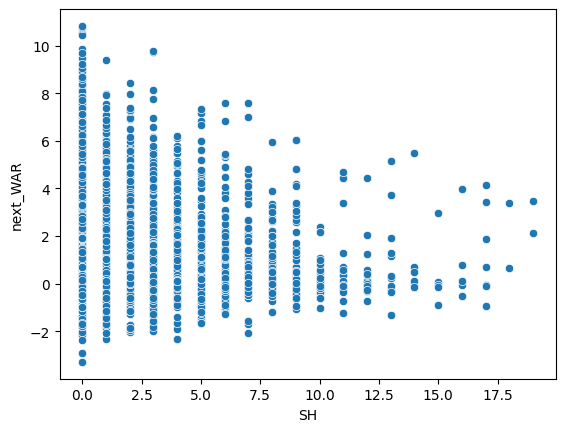

In [22]:
# Use scatterplots to look for non linear relationships between numerical features and response variable
sns.scatterplot(df, x='SH', y='next_WAR')

Text(0.5, 0, 'Correlation')

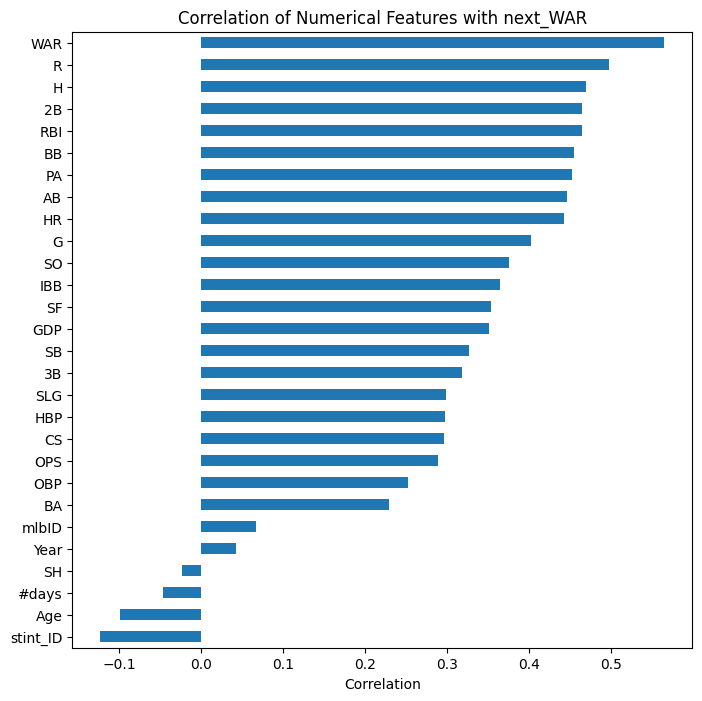

In [23]:
# Relationship between numerical variables and response variable
corr = df.corr(numeric_only=True)["next_WAR"].drop("next_WAR").sort_values()

plt.figure(figsize=(8,8))
corr.plot(kind="barh")
plt.title("Correlation of Numerical Features with next_WAR")
plt.xlabel("Correlation")


Text(0.5, 1.0, 'Correlation Heatmap of Top 12 Variables')

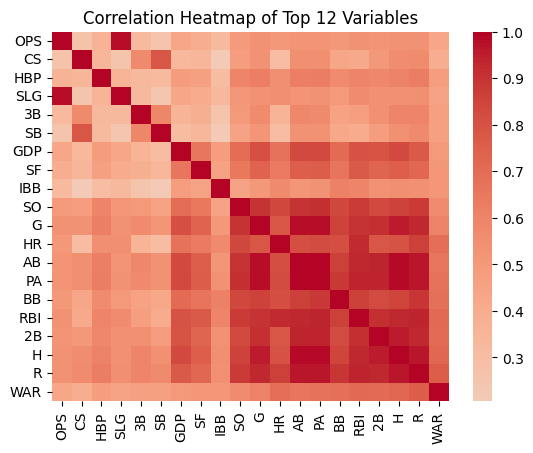

In [24]:
top_vars = corr.abs().sort_values().tail(20).index
sns.heatmap(df[top_vars].corr(), annot=False, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap of Top 12 Variables")

Note: We would likely need PCA or some form of dimensionality reduction, a lot of our features have high correlation within themselves and all of their correlation with nextWAR is around 0.3-0.5. 

Next steps: Check if feature variables do have high correlation. If yes, decide what dimensionality reduction technique to perform


Text(0.5, 1.0, 'Correlation between Hits and Runs')

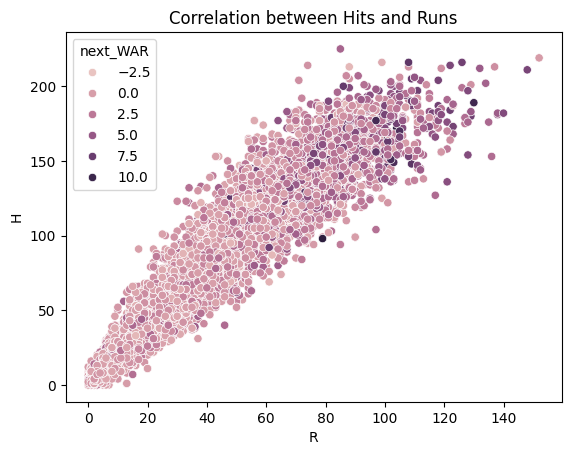

In [25]:
sns.scatterplot(data=df, x="R", y="H", hue="next_WAR")
plt.title("Correlation between Hits and Runs")

Text(0.5, 1.0, 'Correlation between On Base Percentage and Slugging Percentage')

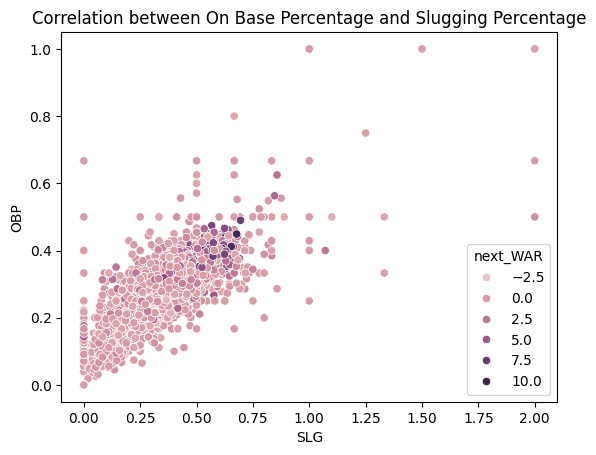

In [26]:
sns.scatterplot(data=df, x="SLG", y="OBP", hue="next_WAR")
plt.title("Correlation between On Base Percentage and Slugging Percentage")

Question: Should we use current year's WAR as a feature?

In [27]:
# preprocessing
# no missing values

numeric_transformer = Pipeline(
    [
        ("scalar", StandardScaler()),
        ("pca", PCA(n_components=0.90)),
    ]
)

categorical_transformer = Pipeline(
    [
        ("encoder", OneHotEncoder()),
    ]
)

preprocessor = ColumnTransformer(
    [
        ("numeric", numeric_transformer, numeric_features),
        ("categorical", categorical_transformer, categorical_features)
    ],
    remainder="drop",
)

In [28]:
pca_df = pd.DataFrame(preprocessor.fit_transform(df))
pca_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,-5.037563,-2.925510,-0.197212,-0.734368,-1.446187,-0.116608,-0.627858,0.349004,-0.013593,0.0,1.0,0.0,0.0,1.0
1,7.064017,-2.534520,-1.815163,0.199772,1.087385,-2.712447,-0.893241,-0.841324,-2.152710,1.0,0.0,1.0,0.0,0.0
2,-4.963851,-3.053374,-0.203850,-1.244411,-0.009256,-1.121651,-0.308125,0.344159,0.271999,0.0,1.0,0.0,0.0,1.0
3,-3.269559,0.004313,-1.784033,-1.290358,0.343166,-0.939467,-0.487469,0.184161,0.092551,1.0,0.0,1.0,0.0,0.0
4,-2.352119,1.332940,-2.468370,-0.921448,-1.175645,0.011239,-0.424740,0.162194,-0.286727,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11757,3.984766,0.293765,1.744131,1.760059,0.814128,-0.939984,0.221508,0.125390,3.378723,1.0,0.0,0.0,0.0,1.0
11758,2.411074,1.925447,0.748391,1.737587,0.439859,-1.681519,1.705429,-0.509263,0.565652,1.0,0.0,0.0,0.0,1.0
11759,-2.773543,2.433999,1.583943,1.189123,-1.063492,0.443042,0.211299,-0.480535,-0.266318,1.0,0.0,0.0,0.0,1.0
11760,2.499248,1.705695,2.409576,-0.038567,1.097159,0.362068,-0.110937,2.482386,-0.165336,1.0,0.0,1.0,0.0,0.0


In [29]:
#sns.scatterplot(pca_df, x=0, y=1)
#plt.yscale('log')

In [30]:
# baseline model 
model = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("lin_model", LinearRegression()),
    ]
)

In [31]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scalar',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=0.9))]),
                                                  ['Age', '#days', 'G', 'PA',
                                                   'AB', 'R', 'H', '2B', '3B',
                                                   'HR', 'RBI', 'BB', 'IBB',
                                                   'SO', 'HBP', 'SH', 'SF',
                                                   'GDP', 'SB', 'CS', 'BA',
                                                   'OBP', 'SLG', 'OPS', 'Year',
                                                   'WAR']),
                                                 ('categorical',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['pitcher', 'Lev'])])),
                ('lin_model', LinearRegression())])

In [32]:
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

In [33]:
print("Train R2:", r2_score(y_true=y_train, y_pred=y_pred_train))
print("Test R2:", r2_score(y_true=y_test, y_pred=y_pred_test))

Train R2: 0.3250813111210664
Test R2: 0.37866119907082585


In [34]:
print("Train RMSE:", root_mean_squared_error(y_true=y_train, y_pred=y_pred_train))
print("Test RMSE:", root_mean_squared_error(y_true=y_test, y_pred=y_pred_test))

Train RMSE: 1.277134469572188
Test RMSE: 1.2973478754163676


In [35]:
print("Train MAE:", mean_absolute_error(y_true=y_train, y_pred=y_pred_train))
print("Test MAE:", mean_absolute_error(y_true=y_test, y_pred=y_pred_test))

Train MAE: 0.8527912103146662
Test MAE: 0.9509657417892157


In [36]:
elasticnet_model = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("elasticnet", ElasticNet(random_state=21, max_iter=1000)),
    ]
)

In [37]:
# grid search cv to tune lasso penalty
param_grid = {
    "elasticnet__alpha":[0.001, 0.01, 0.05, 0.1, 0.5]
}

elasticnet_model_grid = GridSearchCV(elasticnet_model, param_grid=param_grid, cv=5, scoring="neg_mean_absolute_error")
elasticnet_model_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('scalar',
                                                                                          StandardScaler()),
                                                                                         ('pca',
                                                                                          PCA(n_components=0.9))]),
                                                                         ['Age',
                                                                          '#days',
                                                                          'G',
                                                                          'PA',
                                                                          'AB',
                                                                          'R',
                                                                          'H',
                                                                          '2B',
                                                                          '3B',
                                                                          'HR',
                                                                          'RBI',
                                                                          'BB',
                                                                          'IBB',
                                                                          'SO',
                                                                          'HBP',
                                                                          'SH',
                                                                          'SF',
                                                                          'GDP',
                                                                          'SB',
                                                                          'CS',
                                                                          'BA',
                                                                          'OBP',
                                                                          'SLG',
                                                                          'OPS',
                                                                          'Year',
                                                                          'WAR']),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder())]),
                                                                         ['pitcher',
                                                                          'Lev'])])),
                                       ('elasticnet',
                                        ElasticNet(random_state=21))]),
             param_grid={'elasticnet__alpha': [0.001, 0.01, 0.05, 0.1, 0.5]},
             scoring='neg_mean_absolute_error')

In [38]:
elasticnet_model_grid.best_params_

{'elasticnet__alpha': 0.01}

In [39]:
linear_score = elasticnet_model_grid.best_score_
linear_score

np.float64(-0.851496401538039)

In [40]:
y_pred_test = elasticnet_model_grid.predict(X_test)
y_pred_train = elasticnet_model_grid.predict(X_train)

In [41]:
print("Train MAE:", mean_absolute_error(y_true=y_train, y_pred=y_pred_train))
print("Test MAE:", mean_absolute_error(y_true=y_test, y_pred=y_pred_test))

Train MAE: 0.8525368490054263
Test MAE: 0.9520817119303628


## Non-parametric models

Models: 

- Decision Tree 
- KNN 
- Random Forest 
- Histogram Gradient Boosting Regressor

### KNN

In [42]:
knn_model = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("knn", KNeighborsRegressor())
    ]
)

In [43]:
param_grid = {
    "knn__n_neighbors":[10,15,20,30,50,100,250]
}

knn_model_grid = GridSearchCV(knn_model, param_grid=param_grid, cv=5, scoring="neg_mean_absolute_error")
knn_model_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('scalar',
                                                                                          StandardScaler()),
                                                                                         ('pca',
                                                                                          PCA(n_components=0.9))]),
                                                                         ['Age',
                                                                          '#days',
                                                                          'G',
                                                                          'PA',
                                                                          'AB',
                                                                          'R',
                                                                          'H',
                                                                          '2B',
                                                                          '3B',
                                                                          'HR',
                                                                          'RBI',
                                                                          'BB',
                                                                          'IBB',
                                                                          'SO',
                                                                          'HBP',
                                                                          'SH',
                                                                          'SF',
                                                                          'GDP',
                                                                          'SB',
                                                                          'CS',
                                                                          'BA',
                                                                          'OBP',
                                                                          'SLG',
                                                                          'OPS',
                                                                          'Year',
                                                                          'WAR']),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder())]),
                                                                         ['pitcher',
                                                                          'Lev'])])),
                                       ('knn', KNeighborsRegressor())]),
             param_grid={'knn__n_neighbors': [10, 15, 20, 30, 50, 100, 250]},
             scoring='neg_mean_absolute_error')

In [44]:
knn_model_grid.best_params_

{'knn__n_neighbors': 100}

In [45]:
knn_score = knn_model_grid.best_score_
knn_score

np.float64(-0.8365854528064236)

In [46]:
y_pred_test = knn_model_grid.predict(X_test)
root_mean_squared_error(y_true=y_test, y_pred=y_pred_test)

1.3333873040394262

In [47]:
mean_absolute_error(y_true=y_test, y_pred=y_pred_test)

0.9756404411764706

### Decision Tree

In [48]:
tree_model = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("tree", DecisionTreeRegressor(random_state=27, criterion="absolute_error"))
    ]
)

In [49]:
param_grid = {
    "tree__max_depth":[2,3,4,5],
    "tree__max_features":[0.5,0.7,0.85,1],
}

tree_model_grid = GridSearchCV(tree_model, param_grid=param_grid, cv=5, scoring="neg_mean_absolute_error")
tree_model_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('scalar',
                                                                                          StandardScaler()),
                                                                                         ('pca',
                                                                                          PCA(n_components=0.9))]),
                                                                         ['Age',
                                                                          '#days',
                                                                          'G',
                                                                          'PA',
                                                                          'AB',
                                                                          'R',
                                                                          'H',
                                                                          '2B',
                                                                          '3B',
                                                                          'HR',
                                                                          'RBI',
                                                                          'BB',
                                                                          'IBB',
                                                                          'SO',
                                                                          'HBP',
                                                                          'SH',
                                                                          'SF',
                                                                          'GDP',
                                                                          'SB',
                                                                          'CS',
                                                                          'BA',
                                                                          'OBP',
                                                                          'SLG',
                                                                          'OPS',
                                                                          'Year',
                                                                          'WAR']),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder())]),
                                                                         ['pitcher',
                                                                          'Lev'])])),
                                       ('tree',
                                        DecisionTreeRegressor(criterion='absolute_error',
                                                              random_state=27))]),
             param_grid={'tree__max_depth': [2, 3, 4, 5],
                         'tree__max_features': [0.5, 0.7, 0.85, 1]},
             scoring='neg_mean_absolute_error')

In [50]:
tree_model_grid.best_params_

{'tree__max_depth': 4, 'tree__max_features': 0.85}

In [51]:
tree_score = tree_model_grid.best_score_
tree_score

np.float64(-0.819081704143727)

In [52]:
y_pred_test = tree_model_grid.predict(X_test)
root_mean_squared_error(y_true=y_test, y_pred=y_pred_test)

1.3848290800248069

In [53]:
mean_absolute_error(y_true=y_test, y_pred=y_pred_test)

0.9284779411764706

### Random Forest

In [54]:
forest_model = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("forest", RandomForestRegressor(random_state=27, criterion="squared_error", n_estimators=500))
    ]
)

In [55]:
param_grid = {
    "forest__max_depth":[7,10,15],
    "forest__max_features":["sqrt","log2"]
}

forest_model_grid = GridSearchCV(forest_model, param_grid=param_grid, cv=5, scoring="neg_mean_absolute_error")
forest_model_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('scalar',
                                                                                          StandardScaler()),
                                                                                         ('pca',
                                                                                          PCA(n_components=0.9))]),
                                                                         ['Age',
                                                                          '#days',
                                                                          'G',
                                                                          'PA',
                                                                          'AB',
                                                                          'R',
                                                                          'H',
                                                                          '2B',
                                                                          '3B',
                                                                          'HR',
                                                                          'RBI',
                                                                          'BB',
                                                                          'IBB',
                                                                          'SO',
                                                                          'HBP',
                                                                          'SH',
                                                                          'SF',
                                                                          'GDP',
                                                                          'SB',
                                                                          'CS',
                                                                          'BA',
                                                                          'OBP',
                                                                          'SLG',
                                                                          'OPS',
                                                                          'Year',
                                                                          'WAR']),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder())]),
                                                                         ['pitcher',
                                                                          'Lev'])])),
                                       ('forest',
                                        RandomForestRegressor(n_estimators=500,
                                                              random_state=27))]),
             param_grid={'forest__max_depth': [7, 10, 15],
                         'forest__max_features': ['sqrt', 'log2']},
             scoring='neg_mean_absolute_error')

In [56]:
forest_model_grid.best_params_

{'forest__max_depth': 10, 'forest__max_features': 'sqrt'}

In [57]:
forest_score = forest_model_grid.best_score_
forest_score

np.float64(-0.8608935256522783)

In [58]:
y_pred_test = forest_model_grid.predict(X_test)
root_mean_squared_error(y_true=y_test, y_pred=y_pred_test)
mean_absolute_error(y_true=y_test, y_pred=y_pred_test)

0.9831121509513235

### Boosted Model

In [59]:
boosted_model = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("boosted", HistGradientBoostingRegressor(random_state=27))
    ]
)

In [60]:
param_grid = {
    "boosted__loss":["absolute_error","squared_error"],
    "boosted__max_iter":[25,50,100],
    "boosted__learning_rate":[0.01,0.1,0.3,1],
    "boosted__max_depth":[1,2,3,4],
}

boosted_model_grid = GridSearchCV(boosted_model, param_grid=param_grid, cv=5, scoring="neg_mean_absolute_error")
boosted_model_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('scalar',
                                                                                          StandardScaler()),
                                                                                         ('pca',
                                                                                          PCA(n_components=0.9))]),
                                                                         ['Age',
                                                                          '#days',
                                                                          'G',
                                                                          'PA',
                                                                          'AB',
                                                                          'R',
                                                                          'H',
                                                                          '2B',
                                                                          '3B',
                                                                          'HR',
                                                                          'RBI',
                                                                          'BB',
                                                                          'IBB',
                                                                          'SO',
                                                                          'HBP',
                                                                          'SH',
                                                                          'SF',
                                                                          'GDP',
                                                                          'SB',
                                                                          'CS',
                                                                          'BA',
                                                                          'OBP',
                                                                          'SLG',
                                                                          'OPS',
                                                                          'Year',
                                                                          'WAR']),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder())]),
                                                                         ['pitcher',
                                                                          'Lev'])])),
                                       ('boosted',
                                        HistGradientBoostingRegressor(random_state=27))]),
             param_grid={'boosted__learning_rate': [0.01, 0.1, 0.3, 1],
                         'boosted__loss': ['absolute_error', 'squared_error'],
                         'boosted__max_depth': [1, 2, 3, 4],
                         'boosted__max_iter': [25, 50, 100]},
             scoring='neg_mean_absolute_error')

In [61]:
boosted_model_grid.best_params_

{'boosted__learning_rate': 0.1,
 'boosted__loss': 'absolute_error',
 'boosted__max_depth': 3,
 'boosted__max_iter': 50}

In [62]:
boost_score = boosted_model_grid.best_score_
boost_score

np.float64(-0.8073767303553179)

### Conclude models

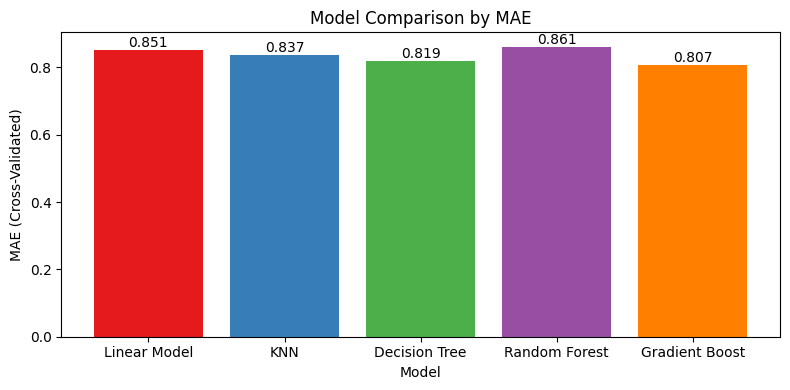

In [63]:
model_names = ["Linear Model", "KNN", "Decision Tree", "Random Forest", "Gradient Boost"]
mae_scores = np.array([linear_score, knn_score, tree_score, forest_score, boost_score]) * -1
plt.figure(figsize=(8,4))
colors = sns.color_palette("Set1", len(model_names))
plt.bar(model_names, mae_scores, color=colors)
plt.ylabel("MAE (Cross-Validated)")
plt.xlabel("Model")
plt.title("Model Comparison by MAE")
for i, score in enumerate(mae_scores):
    plt.text(i, score, f"{score:.3f}", ha='center', va='bottom')
plt.tight_layout()
plt.show()

### Best Model

In [64]:
best_model = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("boosted", HistGradientBoostingRegressor(random_state=27, learning_rate=0.1, loss="absolute_error", max_depth=3, max_iter=50))
    ]
)

best_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scalar',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=0.9))]),
                                                  ['Age', '#days', 'G', 'PA',
                                                   'AB', 'R', 'H', '2B', '3B',
                                                   'HR', 'RBI', 'BB', 'IBB',
                                                   'SO', 'HBP', 'SH', 'SF',
                                                   'GDP', 'SB', 'CS', 'BA',
                                                   'OBP', 'SLG', 'OPS', 'Year',
                                                   'WAR']),
                                                 ('categorical',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['pitcher', 'Lev'])])),
                ('boosted',
                 HistGradientBoostingRegressor(loss='absolute_error',
                                               max_depth=3, max_iter=50,
                                               random_state=27))])

In [73]:
y_pred_test = best_model.predict(X_test)
best_rmse = root_mean_squared_error(y_true=y_test, y_pred=y_pred_test)
best_mae = mean_absolute_error(y_true=y_test, y_pred=y_pred_test)
print("RMSE:", best_rmse)
print("MAE:",best_mae)

RMSE: 1.3680513091905535
MAE: 0.9311361043024735


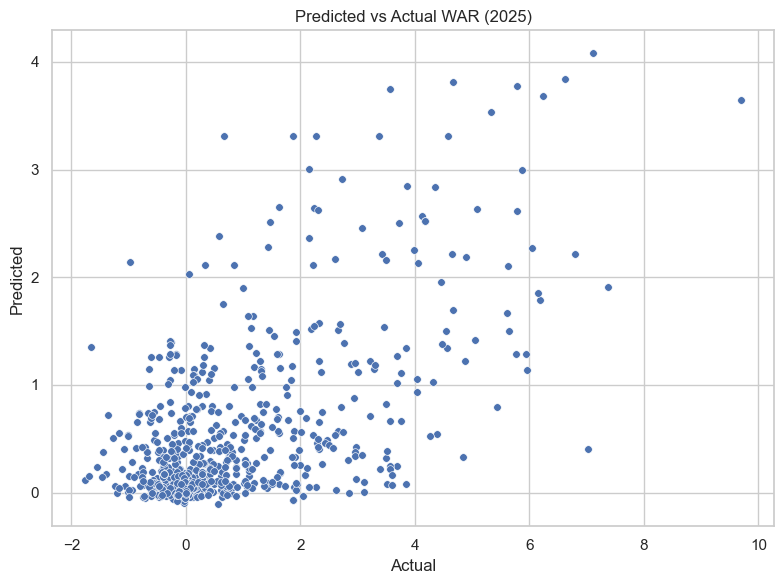

In [66]:
# seaborn style
sns.set(style="whitegrid", context="notebook")
plt.figure(figsize=(8, 6))

# scatter
sns.scatterplot(x=y_test["next_WAR"], y=y_pred_test, s=30)

plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual WAR (2025)")

plt.tight_layout()
plt.show()


### Use the best model to make predictions about 2025 year and see how they compare to actual WAR of these players

In [67]:
# Take a random sample of 10 players from 2024 year
# use their stats to predict 2025 WAR
# compare to actual 2025 WAR

In [68]:
# seed 636 has no negative values

In [69]:
player_names = df_test["name_common"].sample(10, random_state=636)
player_names

12542        Kyle Higashioka
12772        Luis Robert Jr.
12835          Austin Slater
12709              Ryan Noda
12477              Ty France
12511    Lourdes Gurriel Jr.
12687            Dylan Moore
12323            Luis Arráez
12611        Shea Langeliers
12287              CJ Abrams
Name: name_common, dtype: object

In [70]:
results = []

for player in player_names:   # list of player names
    pca_col = df_test[(df_test["name_common"] == player) & (df_test["Year"] == 2024)]

    # Prepare features
    X_pca_col = pca_col.drop(other_columns, axis=1)
    X_pca_col = X_pca_col.drop(response, axis=1)

    # Actual value
    y_real = pca_col["next_WAR"].values[0]

    # Predicted value
    y_pred = best_model.predict(X_pca_col)[0]

    results.append({
        "player": player,
        "actual": y_real,
        "predicted": y_pred
    })

import pandas as pd
results_df = pd.DataFrame(results)
results_df


,player,actual,predicted
0,Kyle Higashioka,1.59,0.142183
1,Luis Robert Jr.,1.40,0.826904
2,Austin Slater,0.28,0.174776
3,Ryan Noda,0.04,-0.025612
4,Ty France,0.75,0.338395
5,Lourdes Gurriel Jr.,0.50,0.511081
6,Dylan Moore,0.19,0.775938
7,Luis Arráez,1.23,0.510200
8,Shea Langeliers,3.85,1.340547
9,CJ Abrams,3.38,3.307247


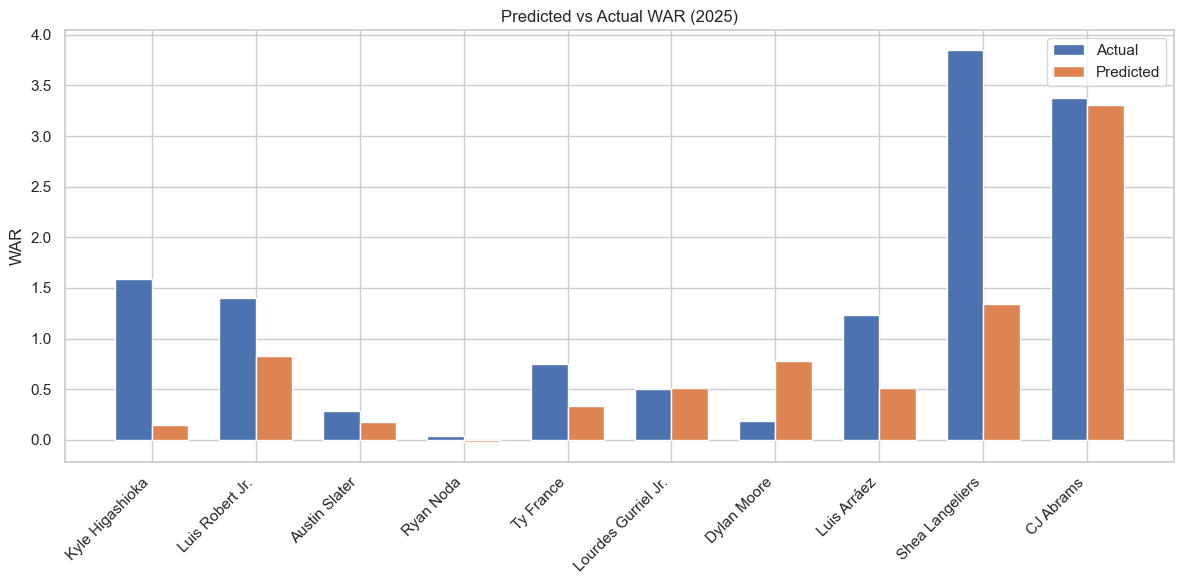

In [71]:
players = results_df["player"]
actual = results_df["actual"]
pred = results_df["predicted"]

x = np.arange(len(players))
width = 0.35

plt.figure(figsize=(12,6))

# Plot
plt.bar(x - width/2, actual, width, label="Actual")
plt.bar(x + width/2, pred, width, label="Predicted")

plt.xticks(x, players, rotation=45, ha="right")
plt.ylabel("WAR")
plt.title("Predicted vs Actual WAR (2025)")
plt.legend()

plt.tight_layout()
plt.show()


## per team calculations